In [28]:
import torch

In [29]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")
plt.ion()

print ("INFO: all the packages are imported.")

INFO: all the packages are imported.


In [30]:
landmarks_frame = pd.read_csv('C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces/face_landmarks.csv')
n = 65

In [31]:
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print ("image name: {}".format(img_name))
print ("landmarks shape: {}".format(landmarks.shape))
print ("first four landmarks : {}".format(landmarks[:4]))

image name: person-7.jpg
landmarks shape: (68, 2)
first four landmarks : [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]]


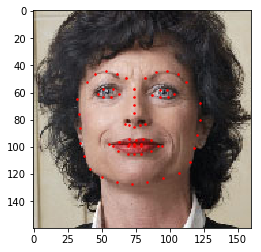

In [32]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:,1], s= 10, marker = '.', c = 'r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread('C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces/' + img_name), landmarks)
plt.show()

In [33]:
## Creation of dataset class for a custom dataset.
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return (len(self.landmarks_frame))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        print ("INFO: image name loaded is : {}".format(img_name))
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\0805personali01.jpg
0 (324, 215, 3) (68, 2)


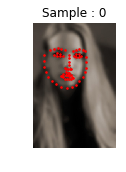

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\1084239450_e76e00b7e7.jpg
1 (500, 333, 3) (68, 2)


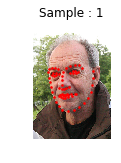

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\10comm-decarlo.jpg
2 (250, 258, 3) (68, 2)


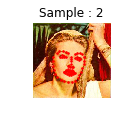

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\110276240_bec305da91.jpg
3 (434, 290, 3) (68, 2)


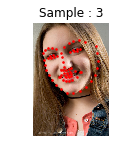

In [34]:
## Load the dataset.
csv_path = "C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces/face_landmarks.csv"
root_dir = "C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces"
face_dataset = FaceLandmarksDataset(csv_file = csv_path, root_dir=root_dir)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print (i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,4, i+1)
    plt.tight_layout()
    ax.set_title('Sample : {}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i== 3:
        plt.show()
        break

In [35]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h,w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h/ w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/ h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}        

In [36]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h,w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top : top + new_h , left : left + new_w]
        
        landmarks = landmarks - [left, top]
        return {
            'image': image,
            'landmarks' : landmarks
        }

In [37]:
class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\person-7.jpg


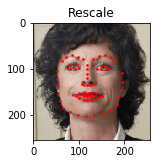

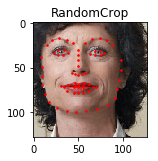

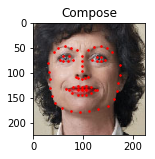

In [38]:
## apply the transformations.
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i+ 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

In [39]:
## apply for the whole dataset.
transformed_dataset = FaceLandmarksDataset(csv_file=csv_path, root_dir=root_dir,
                                          transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))


for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print (i, sample['image'].size(), sample['landmarks'].size())
    if i==3:
        break

INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\0805personali01.jpg
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\1084239450_e76e00b7e7.jpg
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\10comm-decarlo.jpg
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\110276240_bec305da91.jpg
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\2795838930_0cc5aa5f41.jpg
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\252418361_440b75751b.jpg
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\2722779845_7fcb64a096.jpg
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\person_TjahjonoDGondhowiardjo.jpg
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\1084239450_e76e00b7e7.jpg
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\10comm-decarlo.jpg
INFO: image name loaded is : C:/Users/lolla/Documents/Study/Research/pytorch-experiments/datasets/faces\363149951_8be04dc6c0.jpg
INFO: image name loaded is : C:/Users

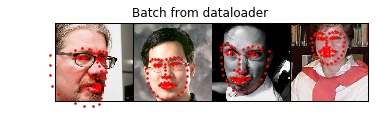

In [41]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break